In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("datasets/10_Industry_Portfolios_Daily.csv", skiprows=9)
df = df.rename(columns={'Unnamed: 0': 'Date'})
df

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,19260701,0.02,-0.28,-0.23,0.57,-0.21,-0.02,-0.01,0.97,0.61,0.20
1,19260702,0.29,1.07,0.81,0.64,0.36,0.26,0.01,0.13,0.47,0.10
2,19260706,0.24,0.72,0.22,0.17,0.47,0.17,-0.23,0.23,0.73,-0.18
3,19260707,0.27,0.06,0.23,-0.04,-0.10,0.32,-0.59,0.33,0.17,0.16
4,19260708,0.69,0.05,0.15,0.12,0.35,0.40,-0.36,0.91,-0.20,0.39
...,...,...,...,...,...,...,...,...,...,...,...
52004,20250527,1.88,3.67,3.05,2.08,3.51,2.23,2.63,1.05,1.01,2.01
52005,20250528,-1.15,-1.14,-0.89,-1.26,-0.55,-0.52,-0.95,0.23,-1.39,-0.88
52006,20250529,0.42,-0.35,0.27,0.21,0.71,-0.25,0.05,1.53,0.70,0.39
52007,20250530,-0.30,-1.04,-0.73,-1.65,-0.51,-0.56,-0.20,-1.24,0.62,-0.10


In [3]:
df = df.replace([-99.99, -999], None).dropna().reset_index(drop=True)

T, N = df.shape # T is the number of periods
N = N - 1 # number of risky assets ignoring date
print('Data for %d assests over %d periods' %(N, T)) # shape of data frame
df.head() # display first 5 rows


Data for 10 assests over 52006 periods


,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,19260701,0.02,-0.28,-0.23,0.57,-0.21,-0.02,-0.01,0.97,0.61,0.20
1,19260702,0.29,1.07,0.81,0.64,0.36,0.26,0.01,0.13,0.47,0.10
2,19260706,0.24,0.72,0.22,0.17,0.47,0.17,-0.23,0.23,0.73,-0.18
3,19260707,0.27,0.06,0.23,-0.04,-0.10,0.32,-0.59,0.33,0.17,0.16
4,19260708,0.69,0.05,0.15,0.12,0.35,0.40,-0.36,0.91,-0.20,0.39


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
start_date = pd.Timestamp('2014-04-30')
end_date = pd.Timestamp('2025-04-30')

# Filter using proper datetime comparison
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)

T, N = df.shape  # Recalculate total periods
N = N - 1  # Adjust for Date column
df.head()

,Date,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,2014-04-30,0.36,0.92,0.66,0.01,0.35,0.86,0.16,0.10,0.10,0.41
1,2014-05-01,-0.21,-0.10,-0.30,-0.48,0.03,0.69,0.09,0.30,0.35,0.00
2,2014-05-02,0.25,0.30,0.16,0.42,-0.21,0.20,0.06,-0.93,-1.53,0.14
3,2014-05-05,0.02,-0.18,0.18,0.45,0.34,0.73,-0.21,0.57,0.71,-0.43
4,2014-05-06,-0.64,-1.21,-0.74,0.10,-1.30,-0.71,-1.42,-1.09,-0.51,-1.27


In [5]:
def getData(df, start, M):
    """returns excess returns for the N assets over a window of M periods from start"""
    return df.loc[start:(start+M-1), df.columns != 'Date'].astype(float).values

def naiveStrategy(N):
    """returns equal weights 1/N for N risky assets"""
    return np.ones(N)/N

def optimalWeights(m, c):
    """returns optimal normalized weights (equation 3 in DeMiguel)
    given mean vector m and covariance matrix c for N risky assets"""
    covI = np.linalg.inv(c) # inverse of covariance
    w = np.matmul(covI, m) # unnormalized optimal weights
    return w/sum(w) # normalized optimal weights

def meanVarianceStrategy(x):
    """returns optimal normalized weights for N risky assets 
    using Markowitz (1952) mean-variance strategy
    based on sample mean and covariance matrix of observations x"""
    m = np.mean(x,axis=0) # mean vector
    c = np.cov(x, rowvar=False)
    return optimalWeights(m, c)

def minVarianceStrategy(x):
    """Minimum variance portfolio (only uses covariance matrix)"""
    c = np.cov(x, rowvar=False)  # Covariance matrix
    ones = np.ones(len(c))       # Vector of ones
    covI = np.linalg.inv(c)
    w = np.matmul(covI, ones)    # Same as DeMiguel equation (8)
    return w/w.sum()             # Normalized weights

def SharpeRatio(returns):
    """returns Sharpe ratio given returns""" 
    m, s = np.mean(returns), np.std(returns)
    return m/s

def returns(df, t, w):
    """Given weight vector w, computes returns in period t"""
    x = getData(df, t, 1)
    return np.matmul(x, w).item()
    

def evaluateNaiveStrategy(M):
    w = naiveStrategy(N) # fixed weights
    res = []
    for t in range(T-M-2):
        x = getData(df, t, M)
        r = returns(df, t+M+1, w)
        res.append(r)
    SR = SharpeRatio(res)
    print('Sharpe Ratio for Naive Strategy = %4.4f' %SR)
    return SR

def evaluateMeanVarianceStrategy(M):
    resInSample, resOutOfSample = [], []
    for t in range(T-M-2):
        x = getData(df, t, M)
        w = meanVarianceStrategy(x)
        ri = returns(df, t+M, w)
        ro = returns(df, t+M+1, w)
        resInSample.append(ri)
        resOutOfSample.append(ro)
    SRI, SRO = SharpeRatio(resInSample), SharpeRatio(resOutOfSample)
    print(f'Sharpe Ratio for Mean Variance Strategy = {SRO:.4f}')
    return SRI, SRO

def evaluateMinVarianceStrategy(M):
    resOutOfSample = []
    for t in range(T-M-2):
        x = getData(df, t, M)
        w = minVarianceStrategy(x)
        ro = returns(df, t+M+1, w)
        resOutOfSample.append(ro)
    SR = SharpeRatio(resOutOfSample)
    print(f'Sharpe Ratio for Min Variance = {SR:.4f}')
    return SR

In [6]:
for M in range(252, 1513, 252):
    print('\nWindow size = %d' % M)
    SR_naive = evaluateNaiveStrategy(M)
    SR_mv_insample, SR_mv = evaluateMeanVarianceStrategy(M)
    SR_minvar = evaluateMinVarianceStrategy(M)


Window size = 252
Sharpe Ratio for Naive Strategy = 0.0331
Sharpe Ratio for Mean Variance Strategy = -0.0054
Sharpe Ratio for Min Variance = 0.0453

Window size = 504
Sharpe Ratio for Naive Strategy = 0.0343
Sharpe Ratio for Mean Variance Strategy = 0.0094
Sharpe Ratio for Min Variance = 0.0302

Window size = 756
Sharpe Ratio for Naive Strategy = 0.0330
Sharpe Ratio for Mean Variance Strategy = 0.0129
Sharpe Ratio for Min Variance = 0.0245

Window size = 1008
Sharpe Ratio for Naive Strategy = 0.0326
Sharpe Ratio for Mean Variance Strategy = -0.0071
Sharpe Ratio for Min Variance = 0.0221

Window size = 1260
Sharpe Ratio for Naive Strategy = 0.0321
Sharpe Ratio for Mean Variance Strategy = 0.0371
Sharpe Ratio for Min Variance = 0.0187

Window size = 1512
Sharpe Ratio for Naive Strategy = 0.0359
Sharpe Ratio for Mean Variance Strategy = 0.0553
Sharpe Ratio for Min Variance = 0.0211


In [7]:
# Parameters
initial_value = 1_000_000

# Get number of assets (assume df is already loaded)
N = len(df.columns) - 1  # Subtract 1 for Date column

# Calculate weights using naive strategy (equal weights)
w = np.ones(N) / N

# Initialize tracking variables
portfolio_value = initial_value
portfolio_values = []
dates = []

# Calculate portfolio values over the entire available period (excluding the first row, which has no prior return)
for t in range(1, len(df)):
    # Get the date
    current_date = pd.to_datetime(df.iloc[t]['Date'])
    
    # Get returns for the current period
    returns_t = df.iloc[t][df.columns != 'Date'].astype(float).values
    
    # Calculate portfolio return for the period
    portfolio_return = np.dot(returns_t, w) / 100  # Divide by 100 since returns are in percentages
    
    # Update portfolio value and store
    portfolio_value *= (1 + portfolio_return)
    
    # Only store after we've calculated the new value
    dates.append(current_date)
    portfolio_values.append(portfolio_value)

# Create a DataFrame
portfolio_df = pd.DataFrame({
    'Date': dates,
    'naive': portfolio_values
})

naive = portfolio_df.iloc[:2767]

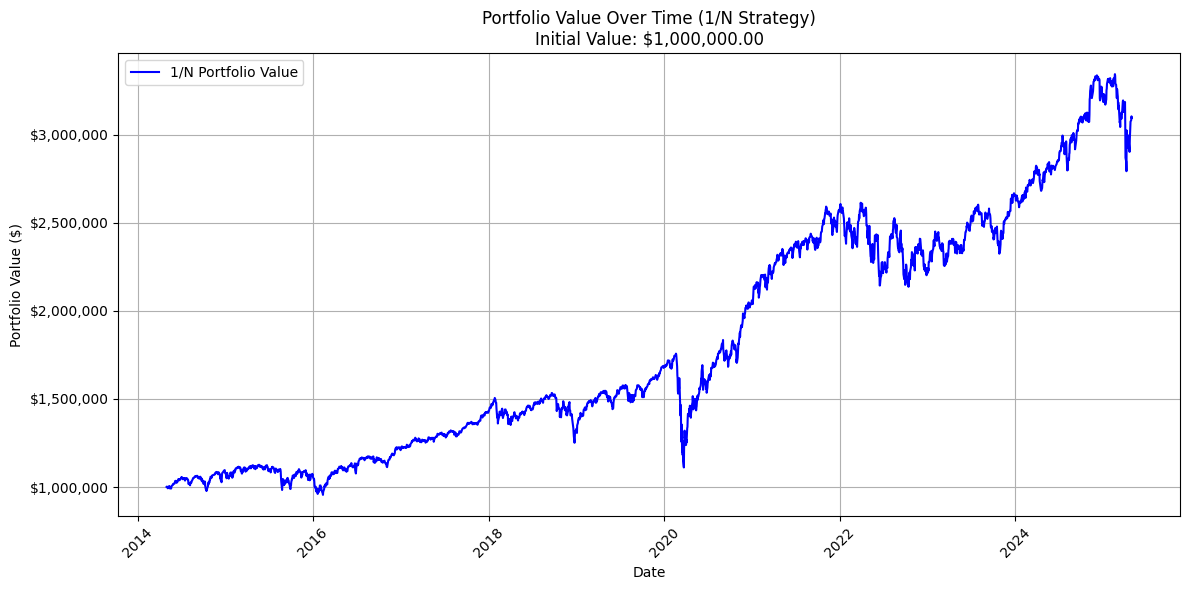

In [8]:

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(naive['Date'], naive['naive'], 'b-', label='1/N Portfolio Value')
plt.title(f'Portfolio Value Over Time (1/N Strategy)\nInitial Value: ${initial_value:,.2f}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()

# Format y-axis to show dollar amounts
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis dates for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# To display the plot, use:
plt.show()

In [10]:
window_size = 252
initial_value = 1_000_000

N = len(df.columns) - 1  

portfolio_value = initial_value
portfolio_values = []
dates = []

for t in range(window_size, len(df)):
    current_date = pd.to_datetime(df.iloc[t]['Date'])
    
    x = df.iloc[t-window_size:t, 1:].astype(float).values  # Exclude 'Date' column
    w = meanVarianceStrategy(x)
    
    returns_t = df.iloc[t, 1:].astype(float).values  # Exclude 'Date' column
    
    portfolio_return = np.dot(returns_t, w) / 100  # Divide by 100 since returns are in percentages
    
    portfolio_value *= (1 + portfolio_return)
    
    dates.append(current_date)
    portfolio_values.append(portfolio_value)

mean_variance_df = pd.DataFrame({
    'Date': dates,
    'mean_variance': portfolio_values
})

mean_variance_df = mean_variance_df.iloc[:2516]
mean_variance_df['mean_variance'] = (mean_variance_df['mean_variance'] /1000000000) + 1e6


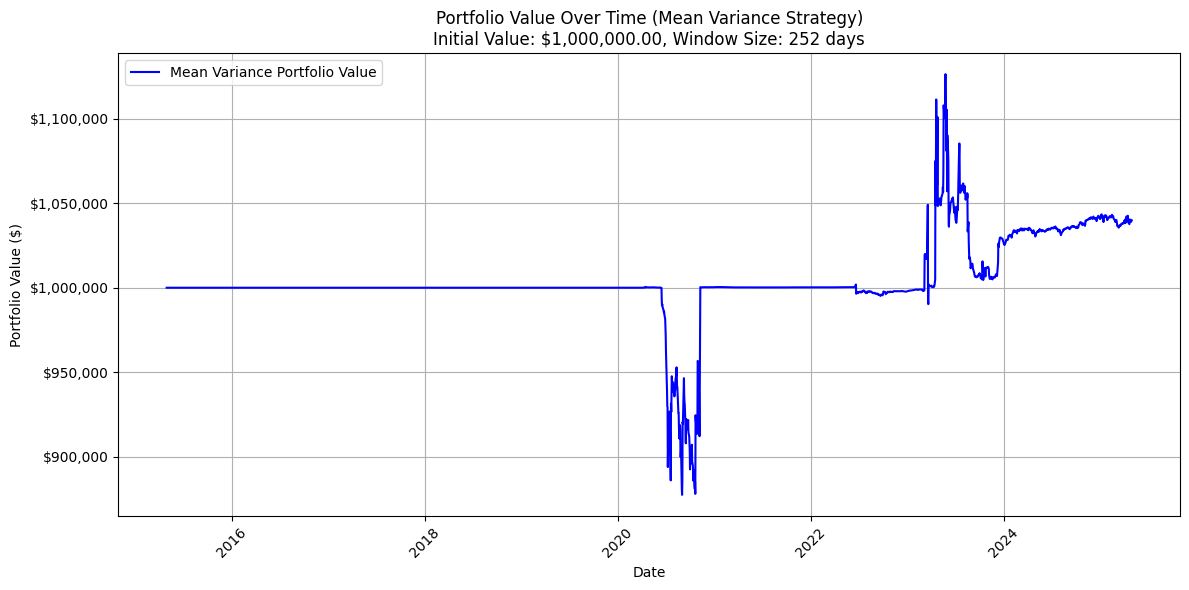

In [13]:

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(mean_variance_df['Date'], mean_variance_df['mean_variance'], 'b-', label='Mean Variance Portfolio Value')
plt.title(f'Portfolio Value Over Time (Mean Variance Strategy)\nInitial Value: ${initial_value:,.2f}, Window Size: {window_size} days')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()

# Format y-axis to show dollar amounts
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis dates for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [14]:
# Get number of assets (assume df is already loaded)
N = len(df.columns) - 1  # Subtract 1 for Date column

# Initialize tracking variables
portfolio_value = initial_value
portfolio_values = []
dates = []

# Calculate portfolio values over the entire available period
for t in range(window_size, len(df)):
    # Get the date
    current_date = pd.to_datetime(df.iloc[t]['Date'])
    
    # Get data for the window, ensuring only asset columns are selected
    x = df.iloc[t-window_size:t, 1:].astype(float).values  # Exclude 'Date' column
    
    # Calculate weights using minimum variance strategy
    w = minVarianceStrategy(x)
    
    # Get returns for the current period
    returns_t = df.iloc[t, 1:].astype(float).values  # Exclude 'Date' column
    
    # Calculate portfolio return for the period
    portfolio_return = np.dot(returns_t, w) / 100  # Divide by 100 since returns are in percentages
    
    # Update portfolio value and store
    portfolio_value *= (1 + portfolio_return)
    
    # Only store after we've calculated the new value
    dates.append(current_date)
    portfolio_values.append(portfolio_value)

# Create a DataFrame
portfolio_df = pd.DataFrame({
    'Date': dates,
    'min_variance': portfolio_values
})

min_variance = portfolio_df.iloc[:2516]
min_variance.to_csv('min_variance.csv', index=False)

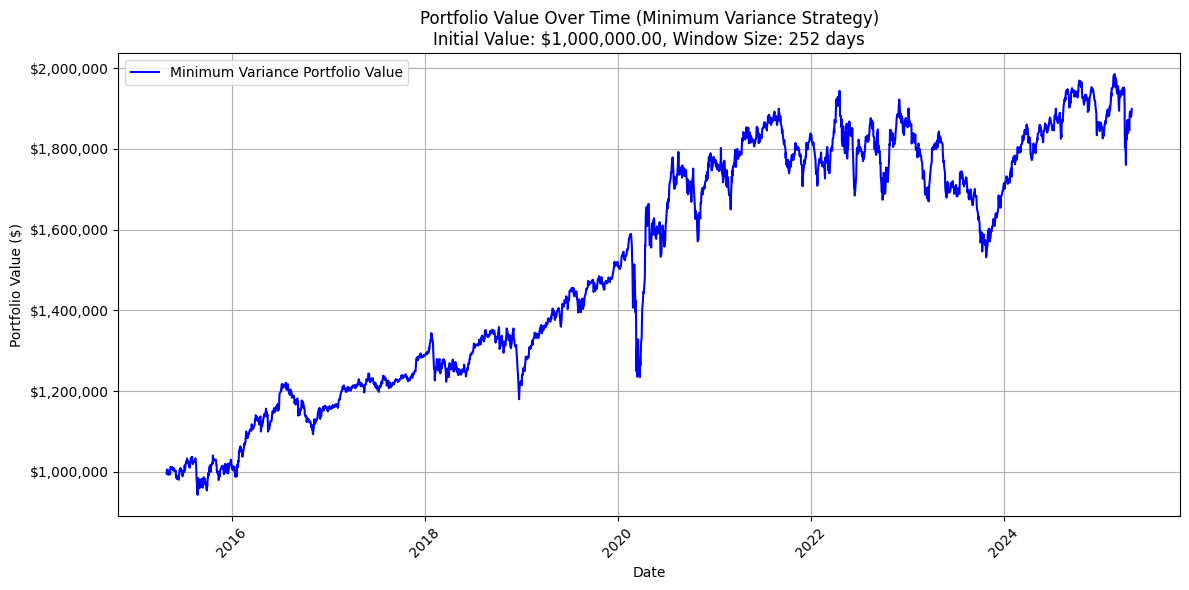

In [15]:

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(min_variance['Date'], min_variance['min_variance'], 'b-', label='Minimum Variance Portfolio Value')
plt.title(f'Portfolio Value Over Time (Minimum Variance Strategy)\nInitial Value: ${initial_value:,.2f}, Window Size: {window_size} days')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()

# Format y-axis to show dollar amounts
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis dates for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [16]:
df = pd.merge(naive, mean_variance_df, on='Date', how='inner')
df = pd.merge(df, min_variance, on='Date', how='inner')
df.head()

,Date,naive,mean_variance,min_variance
0,2015-04-30,1.105723e+06,1.000000e+06,9.950302e+05
1,2015-05-01,1.115575e+06,1.000000e+06,1.005043e+06
2,2015-05-04,1.118576e+06,1.000000e+06,1.005411e+06
3,2015-05-05,1.104918e+06,1.000000e+06,9.945209e+05
4,2015-05-06,1.101338e+06,1.000000e+06,9.923796e+05


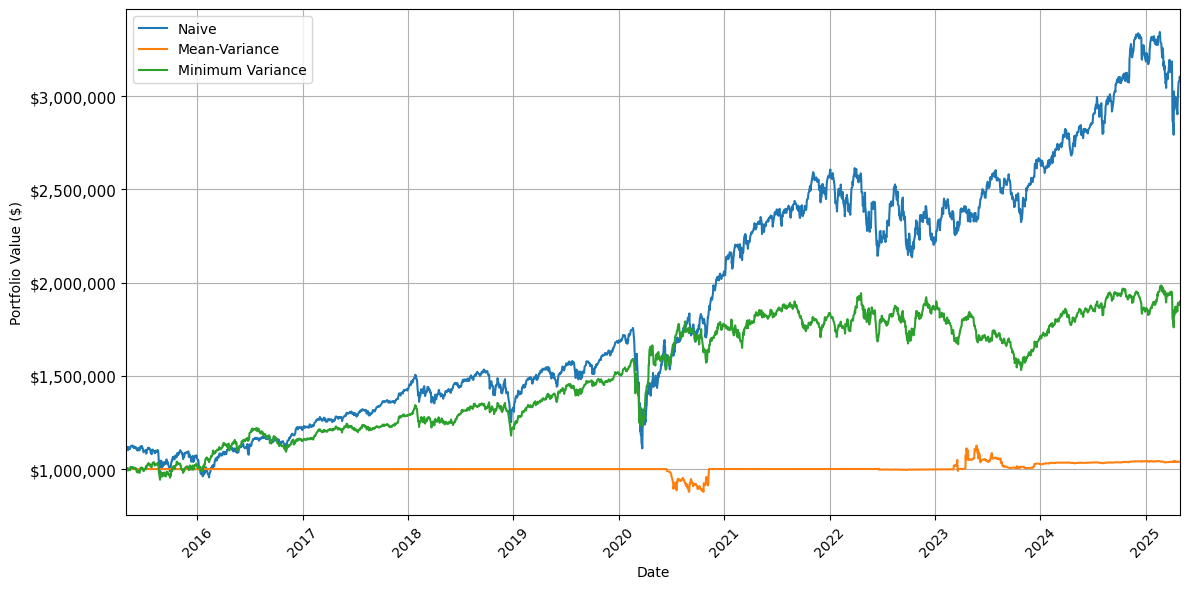

: 

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['naive'], label='Naive')
plt.plot(df['Date'], df['mean_variance'], label='Mean-Variance')
plt.plot(df['Date'], df['min_variance'], label='Minimum Variance')
# plt.title('Portfolio Value Over Time: Naive vs Mean-Variance vs Minimum Variance')
plt.xlim(pd.Timestamp('2015-04-30'), pd.Timestamp('2025-04-30'))
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.yticks(fontsize=11)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.xticks(rotation=45)
plt.tight_layout()
